# Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [3]:
import STAGATE

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "8"

In [5]:
input_dir = '/home/zbdc/github/Data/3D_Hippo/'
data = pd.read_csv(input_dir + '3D_Hippo_expression.txt', sep='\t', index_col=0)
Aligned_coor = pd.read_csv(input_dir + 'ICP_Align_Coor.txt', sep='\t', index_col=0)

In [6]:
Aligned_coor.head()

,X,Y,Z,Section
AAAAACAACCAAT-13,3946.072727,3599.436364,6000,Puck_180531_13
AAAAGTCCATTAT-13,2401.628788,3550.333333,6000,Puck_180531_13
AAACAACGCGCGA-13,2921.968153,3353.687898,6000,Puck_180531_13
AAACAATTCAATA-13,2711.556338,3365.542254,6000,Puck_180531_13
AAACACGCTGCCC-13,2351.863354,4265.447205,6000,Puck_180531_13


In [7]:
adata = sc.AnnData(data)
adata

AnnData object with n_obs × n_vars = 10908 × 9420

In [8]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [9]:
# loading metadata and aligned coordinates
adata.obs['X'] = Aligned_coor.loc[adata.obs_names, 'X']
adata.obs['Y'] = Aligned_coor.loc[adata.obs_names, 'Y']
adata.obs['Z'] = Aligned_coor.loc[adata.obs_names, 'Z']
adata.obs['Section_id'] = Aligned_coor.loc[adata.obs_names, 'Section']

In [10]:
# loading the spatial locations
adata.obsm['spatial'] = adata.obs.loc[:, ['X', 'Y']].values

In [11]:
section_colors = ['#02899A', '#0E994D', '#86C049', '#FBB21F', '#F48022', '#DA5326', '#BA3326']

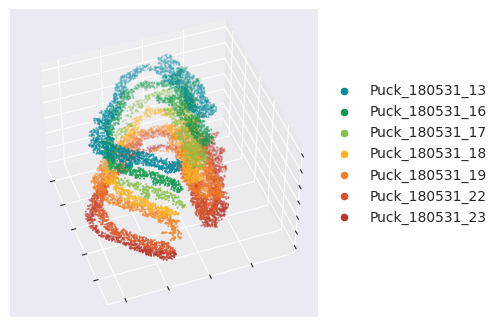

In [12]:
ig = plt.figure(figsize=(4, 4))
ax1 = plt.axes(projection='3d')
for it, label in enumerate(np.unique(adata.obs['Section_id'])):
    temp_Coor = adata.obs.loc[adata.obs['Section_id']==label, :]
    temp_xd = temp_Coor['X']
    temp_yd = temp_Coor['Y']
    temp_zd = temp_Coor['Z']
    ax1.scatter3D(temp_xd, temp_yd, temp_zd, c=section_colors[it],s=0.2, marker="o", label=label)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

plt.legend(bbox_to_anchor=(1,0.8), markerscale=10, frameon=False)

ax1.elev = 45
ax1.azim = -20

plt.show()

# Constructing 3D spatial networks

In [13]:
section_order = ['Puck_180531_13', 'Puck_180531_16', 'Puck_180531_17',
                 'Puck_180531_18', 'Puck_180531_19', 'Puck_180531_22',
                 'Puck_180531_23']

In [14]:
STAGATE.Cal_Spatial_Net_3D(adata, rad_cutoff_2D=50, rad_cutoff_Zaxis=50,
                           key_section='Section_id', section_order = section_order, verbose=True)

Radius used for 2D SNN: 50
Radius used for SNN between sections: 50
------Calculating 2D SNN of section  Puck_180531_13
This graph contains 22974 edges, 1692 cells.
13.5780 neighbors per cell on average.
------Calculating 2D SNN of section  Puck_180531_16
This graph contains 20546 edges, 1476 cells.
13.9201 neighbors per cell on average.
------Calculating 2D SNN of section  Puck_180531_17
This graph contains 11794 edges, 1138 cells.
10.3638 neighbors per cell on average.
------Calculating 2D SNN of section  Puck_180531_18
This graph contains 18278 edges, 1363 cells.
13.4101 neighbors per cell on average.
------Calculating 2D SNN of section  Puck_180531_19
This graph contains 22344 edges, 1788 cells.
12.4966 neighbors per cell on average.
------Calculating 2D SNN of section  Puck_180531_22
This graph contains 24544 edges, 1835 cells.
13.3755 neighbors per cell on average.
------Calculating 2D SNN of section  Puck_180531_23
This graph contains 18922 edges, 1616 cells.
11.7092 neighbors p

# Running STAGATE with 3D spatial networks

In [15]:
adata.X = adata.X.astype('float64')
adata.X 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
adata = STAGATE.train_STAGATE(adata, alpha=0)

Size of Input:  (10908, 3000)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2023-10-23 13:49:50.342738: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-10-23 13:49:50.362679: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2023-10-23 13:49:50.374273: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c94723a4d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-10-23 13:49:50.374311: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-10-23 13:49:50.377060: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-10-23 13:49:50.580395: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c947614ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-23 13:49:50.580460: I tensorflow/compil

In [17]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

In [18]:
num_cluster = 4
adata = STAGATE.mclust_R(adata, num_cluster, used_obsm='STAGATE')

ModuleNotFoundError: No module named 'rpy2'

In [ ]:
adata.uns['Section_id_colors'] = ['#02899A', '#0E994D', '#86C049', '#FBB21F', '#F48022', '#DA5326', '#BA3326']

In [ ]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=['mclust', 'Section_id'])

In [ ]:
fig = plt.figure(figsize=(4, 4))
ax1 = plt.axes(projection='3d')
for it, label in enumerate(np.unique(adata.obs['mclust'])):
    temp_Coor = adata.obs.loc[adata.obs['mclust']==label, :]
    temp_xd = temp_Coor['X']
    temp_yd = temp_Coor['Y']
    temp_zd = temp_Coor['Z']
    ax1.scatter3D(temp_xd, temp_yd, temp_zd, c=adata.uns['mclust_colors'][it],s=0.2, marker="o", label=label)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

plt.legend(bbox_to_anchor=(1.2,0.8), markerscale=10, frameon=False)
plt.title('STAGATE-3D')

ax1.elev = 45
ax1.azim = -20

plt.show()

# Running STAGATE with 2D spatial networks (for comparison)

The 2D spatial networks are saved at adata.uns (‘Spatial_Net_2D’). For camparison, we replace the 3D spatial networks with 2D spatial network and run STAGATE.

In [ ]:
adata_2D = adata.copy()

In [ ]:
adata_2D.uns['Spatial_Net'] = adata.uns['Spatial_Net_2D'].copy()

In [ ]:
adata_2D = STAGATE.train_STAGATE(adata_2D, alpha=0)

In [ ]:
sc.pp.neighbors(adata_2D, use_rep='STAGATE')
sc.tl.umap(adata_2D)

In [ ]:
num_cluster = 4
adata_2D = STAGATE.mclust_R(adata_2D, num_cluster, used_obsm='STAGATE')

In [ ]:
adata_2D.uns['Section_id_colors'] = ['#02899A', '#0E994D', '#86C049', '#FBB21F', '#F48022', '#DA5326', '#BA3326']

In [ ]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_2D, color=['mclust', 'Section_id'])

In [ ]:
fig = plt.figure(figsize=(4, 4))
ax1 = plt.axes(projection='3d')
for it, label in enumerate(np.unique(adata_2D.obs['mclust'])):
    temp_Coor = adata_2D.obs.loc[adata_2D.obs['mclust']==label, :]
    temp_xd = temp_Coor['X']
    temp_yd = temp_Coor['Y']
    temp_zd = temp_Coor['Z']
    ax1.scatter3D(temp_xd, temp_yd, temp_zd, c=adata_2D.uns['mclust_colors'][it],s=0.2, marker="o", label=label)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

plt.legend(bbox_to_anchor=(1.2,0.8), markerscale=10, frameon=False)
plt.title('STAGATE-2D')

ax1.elev = 45
ax1.azim = -20

plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8,8))
sc.pl.umap(adata_2D, color='mclust', title='mclust (STAGATE-2D)', show=False, ax=axs[0,0])
sc.pl.umap(adata_2D, color='Section_id', title='Section_id (STAGATE-2D)', show=False, ax=axs[0,1])
sc.pl.umap(adata, color='mclust', title='mclust (STAGATE-3D)', show=False, ax=axs[1,0])
sc.pl.umap(adata, color='Section_id', title='Section_id (STAGATE-3D)', show=False, ax=axs[1,1])